In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.signal import sepfir2d

In [2]:
imsdir = '../publicdataset/images/'
derivsdir = './FSderivs'
flowsdir = '../publicdataset/flows/FS/'
os.makedirs(flowsdir,exist_ok=True)

In [3]:
# calculate flow, gradient, and condition number at each pixel from derivatives

def FSflow(Ix,Iy,It,taps=3):
    
    # spatial averaging
    if taps in [1,3,5]:
        if taps == 1:
            h = [0,1,0]
        if taps == 3:
            h = [1/4,2/4,1/4]
        if taps == 5:
            h = [1/16,4/16,6/16,4/16,1/16]
    fx2 = sepfir2d( Ix*Ix, h, h )
    fy2 = sepfir2d( Iy*Iy, h, h )
    fxy = sepfir2d( Ix*Iy, h, h )
    fxt = sepfir2d( Ix*It, h, h )
    fyt = sepfir2d( Iy*It, h, h )


    # compute deriv stats and motion 
    cond = np.nan*np.ones_like(Ix)
    grad = np.nan*np.ones_like(Ix)
    xflow = np.nan*np.ones_like(Ix)
    yflow = np.nan*np.ones_like(Ix)
    
    for x in range(np.shape(Ix)[1]):
        for y in range(np.shape(Ix)[0]):
            # build linear system
            M = [[fx2[y,x], fxy[y,x]], [fxy[y,x], fy2[y,x]]]
            b = [[fxt[y,x]], [fyt[y,x]]]
            
            cond[y,x] = np.linalg.cond(M)
            grad[y,x] = np.sqrt(Ix[y,x]*Ix[y,x]+Iy[y,x]*Iy[y,x])
            
            # well-conditioned matrix and large gradient
            #if( np.linalg.cond(M)<1e2 and (np.sqrt(Ix[y,x]*Ix[y,x]+Iy[y,x]*Iy[y,x])>2) ): 
            try:
                v = -np.linalg.inv(M)@b # least-squares solution
                xflow[y,x] = v[0]
                yflow[y,x] = v[1]
            except:
                continue
            
    return xflow,yflow,grad,cond

array([ 7, 13, 20, 27, 33,  7, 13, 20, 27, 33,  7, 13, 20, 27, 33,  7, 13,
       20, 27, 33,  7, 13, 20, 27, 33], dtype=uint8)

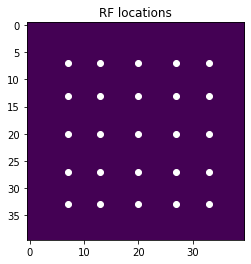

In [6]:
# spatial sampling of RFs

outres = 5
RFxs,RFys = np.meshgrid(np.linspace(0,40,outres+2),np.linspace(0,40,outres+2))
RFxs=np.rint(np.ndarray.flatten(RFxs[1:-1,1:-1])).astype('uint8')
RFys=np.rint(np.ndarray.flatten(RFys[1:-1,1:-1])).astype('uint8')

plt.imshow(np.ones([40,40]))
plt.scatter(RFxs,RFys,c='w')
plt.title('RF locations');
RFxs

In [5]:
# pull up filenames to check for key frames

def listpngnums(vid):
    rawpngs = os.listdir(vid)
    pngnums = sorted([int(png[:-4]) for png in rawpngs])
    return pngnums

In [6]:
# process video: load derivatives, check for key frames, and calculate flows

cams = 2
elevs = 11
frames = 391
derivtaps = 9
flowtaps = 3
fps = 100

def flowsfromderivs(speed,date,RFxs=RFxs,RFys=RFys,taps=flowtaps):
    
    data = np.load(f'{derivsdir}/{speed}/{date}.npz')
    Ix = data['Ix'] # spatial derivatives are in lum/pix = lum/deg
    Iy = data['Iy'] # spatial derivatives are in lum/pix = lum/deg
    It = data['It']*fps # temporal derivatives are in lum/frame, convert to lum/sec
    
    xflow = np.nan*np.ones([cams,elevs,frames,len(RFxs)])
    yflow = np.nan*np.ones_like(xflow)
    grad = np.nan*np.ones_like(xflow)
    cond = np.nan*np.ones_like(xflow)
    
    pngnums = np.array(listpngnums(f'{imsdir}{speed}/{date}'))
    
    for cam in range(cams):
        for elev in range(elevs):
            print(elev,end=' ')
            for frame in range(frames):
                
                # check for key frame
                if np.any(pngnums[frame:frame+derivtaps]%96 == 0):
                    continue
                
                xflw,yflw,grd,cnd = FSflow(Ix[cam,elev,frame],Iy[cam,elev,frame],It[cam,elev,frame],taps=taps)
                                                
                # only save at RF locations
                xflow[cam,elev,frame] = xflw[RFys,RFxs]
                yflow[cam,elev,frame] = yflw[RFys,RFxs]
                grad[cam,elev,frame] = grd[RFys,RFxs]
                cond[cam,elev,frame] = cnd[RFys,RFxs]
                
        np.savez(f'{flowsdir}{speed}/{speed}_{date}',xflow=xflow,yflow=yflow,grad=grad,cond=cond)

In [7]:
speeds = ['Wy_50','Wy_20']
dates = [f'Oct1{i}' for i in range(2,10) if i!=8]

for speed in speeds:
    print('\n'+speed)
    for date in dates:
        print(f'\n\t{date}: ',end='')
        flowsfromderivs(speed,date)


Wy_50

	Oct12: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct13: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct14: 0 

<ipython-input-3-7fa661fa5633>:38: RuntimeWarning: invalid value encountered in matmul
  v = -np.linalg.inv(M)@b # least-squares solution


1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct15: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct16: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct17: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct19: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
Wy_20

	Oct12: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct13: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct14: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct15: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct16: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct17: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 
	Oct19: 0 1 2 3 4 5 6 7 8 9 10 0 1 2 3 4 5 6 7 8 9 10 